In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
#!pip install darts

In [11]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import concatenate,TimeSeries
from darts.dataprocessing.transformers.scaler import Scaler
from darts.metrics import mae, mse, mql
from darts.models import TiDEModel, TSMixerModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.callbacks import TFMProgressBar

In [12]:
tsla_stock_data = pd.read_csv('data/prepared/tsla_feature_data.csv')

In [13]:
tsla_stock_data.tail(5)

,Datetime,correl,linearreg_angle,ema_low,minus_di,bb_middleband,ultosc,bb_upperband,beta,cci,macdhist,mom,bb_lowerband,adosc,sentscore,return
3626,2024-05-02 04:00:00,-1.0,-11.545101,178.448261,2.972921,178.389999,1.055151,178.389999,0.0,-66.666667,-0.060128,-1.604996,178.389999,-4.599094e+07,-0.2023,0.0
3627,2024-05-02 04:30:00,-1.0,-8.846312,178.416506,2.694604,178.389999,0.560811,178.389999,0.0,-58.333333,-0.038476,-1.604996,178.389999,-4.710696e+07,0.0000,0.0
3628,2024-05-02 05:00:00,-1.0,-5.003216,178.395336,2.447818,178.389999,0.561378,178.389999,0.0,-51.851852,-0.016685,-1.604996,178.389999,-4.802682e+07,0.0000,0.0
3629,2024-05-02 05:30:00,-1.0,-0.000000,178.381223,2.228064,178.389999,0.565814,178.389999,0.0,-46.666667,0.004089,-1.604996,178.389999,-4.878282e+07,-0.1318,0.0
3630,2024-05-02 06:00:00,-1.0,-0.000000,178.371814,2.031642,178.389999,0.570011,178.389999,0.0,-42.424242,0.023128,0.000000,178.389999,-4.940305e+07,0.3612,0.0


In [14]:
tsla_stock_data_ts = TimeSeries.from_dataframe(tsla_stock_data,
                                               time_col='Datetime',
                                               freq='30min')

In [15]:
tsla_stock_data_ts = tsla_stock_data_ts.astype(np.float32)

In [16]:
tsla_stock_data_ts.columns

Index(['correl', 'linearreg_angle', 'ema_low', 'minus_di', 'bb_middleband',
       'ultosc', 'bb_upperband', 'beta', 'cci', 'macdhist', 'mom',
       'bb_lowerband', 'adosc', 'sentscore', 'return'],
      dtype='object', name='component')

In [17]:
tsla_stock_data_ts_target = tsla_stock_data_ts['return']
tsla_stock_data_ts_past = tsla_stock_data_ts[['correl', 'linearreg_angle', 'ema_low', 'minus_di', 'bb_middleband',
       'ultosc', 'bb_upperband', 'beta', 'cci', 'macdhist', 'mom',
       'bb_lowerband', 'adosc','sentscore']]
#tsla_stock_data_ts_future = tsla_stock_data_ts['sentscore']

In [18]:
# train, val, test = [], [], []
# for trafo in tsla_stock_data_ts_target:
#     train_, temp = tsla_stock_data_ts_target.split_after(0.6)
#     val_, test_ = temp.split_after(0.5)
#     train.append(train_)
#     val.append(val_)
#     test.append(test_)
train, test = tsla_stock_data_ts_target.split_after(0.6)

In [19]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [20]:
train_past, train_past = tsla_stock_data_ts_past.split_after(0.6)

scaler_past = Scaler()  # default uses sklearn's MinMaxScaler
train_past = scaler_past.fit_transform(train_past)
tsla_stock_data_ts_past = scaler_past.transform(tsla_stock_data_ts_past)

In [21]:
# train_future, train_future = tsla_stock_data_ts_future.split_after(0.6)

# scaler_future = Scaler()  # default uses sklearn's MinMaxScaler
# train_future = scaler_future.fit_transform(train_future)
# tsla_stock_data_ts_future = scaler_future.transform(tsla_stock_data_ts_future)

In [22]:
def create_params(
    input_chunk_length: int,
    output_chunk_length: int,
    full_training=True,
):
    quantiles = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
    #quantiles = [0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
    # early stopping: this setting stops training once the the validation
    # loss has not decreased by more than 1e-5 for 10 epochs
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=1e-5,
        mode="min",
    )

    # PyTorch Lightning Trainer arguments (you can add any custom callback)
    if full_training:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 200
        batch_size = 256
    else:
        limit_train_batches = 20
        limit_val_batches = 10
        max_epochs = 3
        batch_size = 64

    # only show the training and prediction progress bars
    progress_bar = TFMProgressBar(
        enable_sanity_check_bar=False, enable_validation_bar=False
    )
    pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        #"callbacks": [early_stopper, progress_bar],
        "callbacks": [progress_bar],
        # "accelerator": "gpu",
        # "devices": [0]
    }

    # optimizer setup, uses Adam by default
    optimizer_cls = torch.optim.Adam
    optimizer_kwargs = {
        "lr": 1e-4,
    }

    # learning rate scheduler
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    # for probabilistic models, we use quantile regression, and set `loss_fn` to `None`
    likelihood = QuantileRegression(quantiles=quantiles)
    loss_fn = None

    return {
        "input_chunk_length": input_chunk_length,  # lookback window
        "output_chunk_length": output_chunk_length,  # forecast/lookahead window
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # use a `likelihood` for probabilistic forecasts
        "loss_fn": loss_fn,  # use a `loss_fn` for determinsitic model
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,
        "add_encoders": {
            "cyclic": {
                "future": ["hour", "dayofweek", "month"]
            }  # add cyclic time axis encodings as future covariates
        },
    }

In [23]:
input_chunk_length = 20 * 24
output_chunk_length = 10*24
use_static_covariates = True
full_training = False

In [24]:
model_tsm = TSMixerModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training,
    ),
    use_static_covariates=use_static_covariates,
    model_name="tsm"
)

In [25]:
model_tsm.fit(series=tsla_stock_data_ts_target,
              past_covariates=tsla_stock_data_ts_past,
              #future_covariates=tsla_stock_data_ts_future
              )

Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.43it/s, train_loss=0.0111]


TSMixerModel(output_chunk_shift=0, hidden_size=64, ff_size=64, num_blocks=2, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, input_chunk_length=480, output_chunk_length=240, use_reversible_instance_norm=True, optimizer_kwargs={'lr': 0.0001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 3, 'limit_train_batches': 20, 'limit_val_batches': 10, 'accelerator': 'auto', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x30f147410>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), loss_fn=None, save_checkpoints=True, force_reset=True, batch_size=64, random_state=42, add_encoders={'cyclic': {'future': ['hour', 'dayofweek', 'month']}}, model_name=tsm)

In [26]:
pred = model_tsm.predict(n=10*24,
                         past_covariates=tsla_stock_data_ts_past,
                         #future_covariates=tsla_stock_data_ts_future
                         predict_likelihood_parameters=True
                         )

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


In [27]:
pred.pd_dataframe()

component,return_q0.01,return_q0.05,return_q0.10,return_q0.15,return_q0.20,return_q0.25,return_q0.30,return_q0.40,return_q0.50,return_q0.60,return_q0.70,return_q0.75,return_q0.80,return_q0.85,return_q0.90,return_q0.95,return_q0.99
Datetime,,,,,,,,,,,,,,,,,
2024-05-02 06:30:00,-0.003743,-0.005214,-0.001947,0.000213,0.000711,-0.000683,-0.000867,-0.001215,0.002411,0.001520,0.001302,0.002068,0.001950,0.003331,0.004438,0.008971,0.010686
2024-05-02 07:00:00,-0.002900,-0.002875,-0.001432,0.000429,0.000997,-0.001085,-0.000687,-0.000435,0.000880,0.000646,0.000620,0.001499,0.001050,0.002303,0.003729,0.004628,0.005095
2024-05-02 07:30:00,-0.003633,-0.003366,-0.001206,-0.000380,0.000003,-0.000712,-0.000712,-0.000366,0.000928,0.000999,0.001921,0.001731,0.002484,0.002563,0.003654,0.007124,0.009414
2024-05-02 08:00:00,-0.006647,-0.006573,-0.002881,0.000043,0.000180,-0.001127,-0.000993,-0.001618,0.003627,0.001327,0.002597,0.002444,0.002440,0.004431,0.006076,0.012174,0.015777
2024-05-02 08:30:00,-0.002698,-0.003688,-0.001990,0.000305,-0.000167,0.000246,-0.000649,-0.001579,0.001102,0.000980,0.002169,0.001650,0.002693,0.003219,0.003817,0.004929,0.006638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07 04:00:00,-0.005785,-0.004797,-0.001908,-0.000459,0.000281,-0.000623,-0.001045,-0.000933,0.001175,0.001064,0.001525,0.001712,0.001858,0.003088,0.004136,0.008440,0.008458
2024-05-07 04:30:00,-0.004636,-0.004759,-0.002770,-0.001002,0.000390,-0.000302,-0.000813,-0.000797,0.000167,0.000631,0.001453,0.000660,0.001914,0.002607,0.003742,0.007749,0.010343
2024-05-07 05:00:00,-0.004232,-0.002483,-0.002066,-0.000165,0.000976,-0.000435,-0.001308,-0.000617,0.000242,0.000215,0.001798,0.000564,0.001224,0.002588,0.004479,0.006640,0.006088


In [28]:
# before starting, we define some constants
num_samples = 500

figsize = (10, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [29]:
from darts.metrics import mape
from datetime import datetime, timedelta

In [30]:
def eval_model(model, forecast_horizon, actual_series):
    pred_series = model.predict(n=forecast_horizon,
                                past_covariates=tsla_stock_data_ts_past,
                                predict_likelihood_parameters=True)
    pred_series = pred_series[['return_q0.90','return_q0.95','return_q0.99']]

    # Rescale data to real value (Inverse transform)
    pred_series = scaler.inverse_transform(pred_series)
    actual_series = scaler.inverse_transform(actual_series)

    # plot actual series
    plt.figure(figsize=figsize)
    end = pred_series.end_time()
    start = end - timedelta(days=30)
    actual_series[start:end].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    #pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.95it/s]


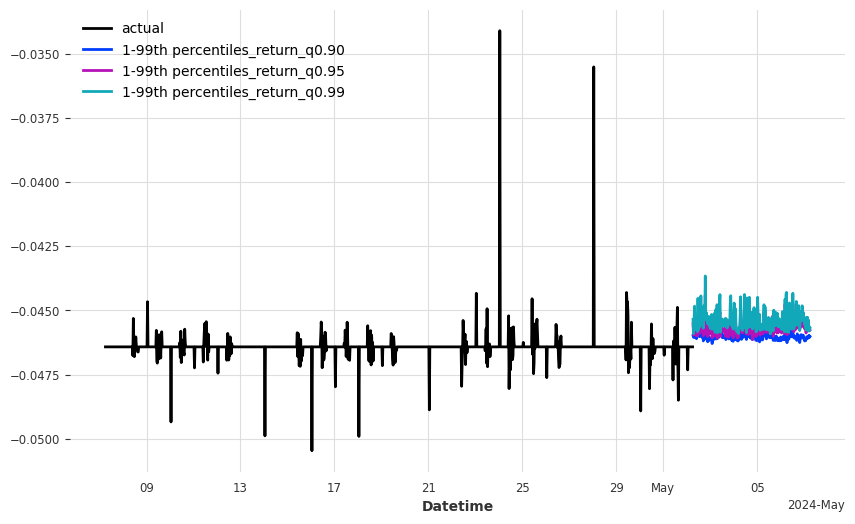

In [31]:
eval_model(model_tsm,240,tsla_stock_data_ts_target)

In [39]:
# Save the model
model_tsm.save('model/tsla_tsm')

# Backtest the probabilistic models

In [32]:
# configure the probabilistic prediction
num_samples = 300
forecast_horizon = output_chunk_length

# compute the Mean Quantile Loss over these quantiles
evaluate_quantiles = [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]

In [33]:
def historical_forecasts(model):
    """Generates probabilistic historical forecasts for each transformer
    and returns the inverse transformed results.

    Each forecast covers 5*24h (forecast_horizon). The time between two forecasts
    (stride) is also 5*24 hours.
    """
    returnVal = model.historical_forecasts(
        series=tsla_stock_data_ts_target,
        forecast_horizon=forecast_horizon,
        stride=forecast_horizon,
        last_points_only=False,
        retrain=False,
        #num_samples=num_samples,
        past_covariates=tsla_stock_data_ts_past,
        #future_covariates=tsla_stock_data_ts_future,
        verbose=True,
    )
    return scaler.inverse_transform(returnVal[0])
    #return returnVal

In [34]:
print("Generating historical forecasts..")
hfcs = historical_forecasts(model_tsm)

Generating historical forecasts..
Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


In [35]:
hfcs.pd_dataframe()

component,return
Datetime,
2024-02-26 15:00:00,-0.046394
2024-02-26 15:30:00,-0.046420
2024-02-26 16:00:00,-0.046240
2024-02-26 16:30:00,-0.046021
2024-02-26 17:00:00,-0.046360
...,...
2024-03-02 12:30:00,-0.046392
2024-03-02 13:00:00,-0.046528
2024-03-02 13:30:00,-0.046202
